# Data-driven Models of the Activated Sludge 

## Preamble

In [1]:
# Here all the required packages are loaded
import numpy as np
import os
import plotly.express as px
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import pandas as pd
from pymatreader import read_mat
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import PredefinedSplit
from sklearn.svm import SVR
from hypopt import GridSearch
import seaborn as sns
from sklearn.linear_model import Ridge
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import tree
from scipy import stats
import rpy2
from rpy2.robjects.packages import importr
from ipywidgets import widgets, interactive, interact

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """


## Loading and preparation of the data

First we load the data from a local directory.

The data is available from my Google drive at:
https://drive.google.com/file/d/183sbF1tTeYw0HyxDqr-7paquMeNOuLp2/view?usp=sharing

In [2]:
# Redirect to the directory where the file is located
directory = '/Users/Sebastian/Documents/Leif/DTU/Speciale/Runs'
os.chdir(directory)

# Load the file with the pymatreader function read_mat
data_mat = read_mat('Data.mat')

Second we need to create dataframes with th eproper labeling where we can load the different data-sets. The data file includes matrices for both the effluent and biogas modelling, however for this notebook we will focus on the effluent modelling

In [3]:
# Defining column names
#Input variable names
Header_X_in = ['Q','T','TSS',r'$\mathbf{NO_{x}}$', r'$\mathbf{NH_4}$', r'$\mathbf{CH_3COO^-}$', r'$\mathbf{PO^{3-}_4}$', 'kLa', 'pH']

#Output variable names
Header_out = ['TSS', r'$\mathbf{NO_{x}}$', r'$\mathbf{NH_4}$', r'$\mathbf{PO^{3-}_4}$']

In [4]:
# Creating a Pandas dataframe for the 9 different data sets.
X_a = pd.DataFrame(data_mat['in_sensor'], columns = Header_X_in)
X_b = pd.DataFrame(data_mat['reac1_sensor'], columns = Header_X_in)
X_c = pd.DataFrame(data_mat['reac2_sensor'], columns = Header_X_in)
X_d = pd.DataFrame(data_mat['reac2_combine'], columns = Header_X_in)
X_e = pd.DataFrame(data_mat['reac3_sensor'], columns = Header_X_in)
X_f = pd.DataFrame(data_mat['reac4_sensor'], columns = Header_X_in)
X_g = pd.DataFrame(data_mat['reac5_sensor'], columns = Header_X_in)
X_h = pd.DataFrame(data_mat['reac6_sensor'], columns = Header_X_in)
X_i = pd.DataFrame(data_mat['reac7_sensor'], columns = Header_X_in)

# Creating a Pandas dataframe for the settler effluent data set.
y = pd.DataFrame(data_mat['Effluent'], columns = Header_out)

In [5]:
X_i.head()

Q          T          TSS  $\mathbf{NO_{x}}$  $\mathbf{NH_4}$  \
0  97998.980890  19.984583  3268.544451           5.402000         0.116835   
1  97123.716790  19.900587  3285.302079           5.373243         0.114244   
2  96986.294581  19.866849  3282.020632           5.326669         0.112673   
3  95766.884418  19.927777  3278.153089           5.246972         0.111425   
4  95563.134014  19.816241  3285.145222           5.208108         0.110389   

   $\mathbf{CH_3COO^-}$  $\mathbf{PO^{3-}_4}$        kLa        pH  
0              0.005902              3.972761  59.906928  7.836899  
1              0.006036              3.884926  58.337373  7.831361  
2              0.006132              3.849829  56.687453  7.820751  
3              0.006243              3.805393  54.854707  7.799458  
4              0.006437              3.762349  53.269879  7.816487

We now split the data into training and test data. We are not shuffling the data, since we are doing time-series modelling further on, and the data hasn't been ordered in anyway apart from by time.

In [9]:
X_a_train, X_a_test, X_b_train, X_b_test, X_c_train, X_c_test, X_d_train, X_d_test, X_e_train, X_e_test, X_f_train, X_f_test, X_g_train, X_g_test, X_h_train, X_h_test, X_i_train, X_i_test, y_train, y_test = train_test_split(X_a, X_b, X_c, X_d, X_e, X_f, X_g, X_h, X_i, y, test_size = 0.2, shuffle = False)

In [10]:
class CVMethod:
    def __init__(self, X_train, y_train, X_test, y_test, param_dict, Method):
        self.pipeline = Pipeline([
            ('scale', StandardScaler()),
            ('clf', Method)
        ])
        
        self.param_grid = param_dict
        self.grid = GridSearchCV(self.pipeline, param_grid = self.param_grid, cv = 3, verbose = False, n_jobs = -1)
        
        self.grid.fit(X_train, y_train)
        self.predictions = self.grid.predict(X_test)
        self.residuals = y_test - self.predictions.ravel()
        self.RMSE = np.mean((self.residuals)**2)**0.5

In [11]:
param_linreg = {}
param_PLS = {'clf__n_components':  [int(x) for x in np.linspace(1,9,9)]}
param_KNN = {'clf__n_neighbors': [int(x) for x in np.linspace(2,200,100)]}
param_RF = {'clf__max_features': [int(x) for x in np.linspace(1,9,9)]}

In [12]:
class Models:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.linreg = CVMethod(X_train, y_train, X_test, y_test, param_linreg, LinearRegression())
        self.PLS = CVMethod(X_train, y_train, X_test, y_test, param_PLS, PLSRegression())
        self.KNN = CVMethod(X_train, y_train, X_test, y_test, param_KNN, KNeighborsRegressor())
        self.RF = CVMethod(X_train, y_train, X_test, y_test, param_RF, RandomForestRegressor(n_estimators = 100))

In [13]:
class Model_Variables:
    def __init__(self, X_train, X_test):
        self.TSS = Models(X_train, y_train[Header_out[0]], X_test, y_test[Header_out[0]])
        self.NOx = Models(X_train, y_train[Header_out[1]], X_test, y_test[Header_out[1]])
        self.NH4 = Models(X_train, y_train[Header_out[2]], X_test, y_test[Header_out[2]])
        self.PO4 = Models(X_train, y_train[Header_out[3]], X_test, y_test[Header_out[3]])

In [14]:
X_a_model = Model_Variables(X_a_train, X_a_test)

/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:351: UserWarning: X scores are null at iteration 8
  warnings.warn('X scores are null at iteration %s' % k)


In [19]:
X_b_model = Model_Variables(X_b_train, X_b_test)

/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:351: UserWarning: X scores are null at iteration 8
  warnings.warn('X scores are null at iteration %s' % k)


In [20]:
X_c_model = Model_Variables(X_c_train, X_c_test)

/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:351: UserWarning: X scores are null at iteration 8
  warnings.warn('X scores are null at iteration %s' % k)


In [21]:
X_d_model = Model_Variables(X_d_train, X_d_test)

In [22]:
X_e_model = Model_Variables(X_e_train, X_e_test)

In [23]:
X_f_model = Model_Variables(X_f_train, X_f_test)

In [24]:
X_g_model = Model_Variables(X_g_train, X_g_test)

In [25]:
X_h_model = Model_Variables(X_h_train, X_h_test)

In [26]:
X_i_model = Model_Variables(X_i_train, X_i_test)

In [27]:
dict_models = {'X_a_model':X_a_model, 
       'X_b_model':X_b_model, 
       'X_c_model':X_c_model, 
       'X_d_model':X_d_model,
       'X_e_model':X_e_model,
       'X_f_model':X_f_model, 
       'X_g_model':X_g_model,
       'X_h_model':X_h_model,
       'X_i_model':X_i_model}
dict_list = list(dict_models.keys())

In [45]:
dict_rf_feature_importance = {'TSS':[],'NOx':[],'NH4':[],'PO4':[]}
dict_rf_max_features = {'TSS':[],'NOx':[],'NH4':[],'PO4':[]}
dict_KNN_neighbors = {'TSS':[],'NOx':[],'NH4':[],'PO4':[]}
dict_PLS_n_components = {'TSS':[],'NOx':[],'NH4':[],'PO4':[]}
dict_OLS_beta_intercept = {'TSS':[],'NOx':[],'NH4':[],'PO4':[]}

for attr, value in X_a_model.__dict__.items():
      dict_rf_feature_importance[attr] = X_a_model.TSS.RF.grid.best_estimator_['clf'].feature_importances_
      dict_rf_max_features[attr]  = X_a_model.TSS.RF.grid.best_estimator_['clf'].max_features
      dict_KNN_neighbors[attr] = X_a_model.TSS.KNN.grid.best_estimator_['clf'].n_neighbors
      dict_PLS_n_components[attr] = X_a_model.TSS.PLS.grid.best_estimator_['clf'].n_components
    
    

In [48]:
for key in dict_models:
    for attr, value in dict_models[key].__dict__.items():
        a = value.RF.grid.best_estimator_['clf'].feature_importances_;
        dict_rf_feature_importance[attr] = np.vstack((dict_rf_feature_importance[attr],a));
        
        b = value.RF.grid.best_estimator_['clf'].max_features
        dict_rf_max_features[attr] = np.vstack((dict_rf_max_features[attr],b));
        
        c = value.KNN.grid.best_estimator_['clf'].n_neighbors
        dict_KNN_neighbors[attr] = np.vstack((dict_KNN_neighbors[attr],c));
        
        d = value.PLS.grid.best_estimator_['clf'].n_components
        dict_PLS_n_components[attr] = np.vstack((dict_PLS_n_components[attr],d));
        
        
        
#This deletes the first duplicate column
for key in dict_rf_feature_importance:
    dict_rf_feature_importance[key] = np.delete(dict_rf_feature_importance[key], (0), axis = 0)
    dict_rf_max_features[key] = np.delete(dict_rf_max_features[key], (0), axis = 0)
    dict_KNN_neighbors[key] = np.delete(dict_KNN_neighbors[key], (0), axis = 0)
    dict_PLS_n_components[key] = np.delete(dict_PLS_n_components[key], (0), axis = 0)
    
    
    
    
    

In [31]:
dict_linreg = {'TSS':[],'NOx':[],'NH4':[],'PO4':[]}
dict_plscomp = {'TSS':[],'NOx':[],'NH4':[],'PO4':[]}
for key in dict_models:
    for attr, value in dict_models[key].__dict__.items():
        a = value.linreg.grid.best_estimator_['clf'].coef_
        a = np.append(a,value.linreg.grid.best_estimator_['clf'].intercept_)
        dict_linreg[attr] = np.append(dict_linreg[attr],a)
        
        b = value.PLS.grid.cv_results_['mean_test_score']
        dict_plscomp[attr] = np.append(dict_plscomp[attr],b)

In [32]:
cols = ['Q','T','TSS',r'$\mathbf{NO_{x}}$', r'$\mathbf{NH_4}$', r'$\mathbf{CH_3COO^-}$', r'$\mathbf{PO^{3-}_4}$', 'kLa', 'pH', 'Intercept']
index = ['a','b','c','d','e','f','g','h','i']
for key in dict_linreg:
    dict_linreg[key] = dict_linreg[key].reshape(9,10)
    dict_plscomp[key] = dict_plscomp[key].reshape(9,9)



In [33]:
import plotly.io as pio
pio.renderers.default='notebook'

In [34]:
fig = ff.create_annotated_heatmap(np.round(dict_linreg['TSS'],2), x = cols, y = index)
fig['data'][0]['showscale'] = True
fig['layout']['yaxis']['autorange'] = 'reversed'
fig['layout']['xaxis']['side'] = 'bottom'
fig['layout']['title'] = r'$\text{Heatmap of OLS coefficients and Intercept for TSS Models}$'
fig.update_layout(title_x=0.5)
fig['layout']['xaxis_title'] = 'Variable Name'
fig['layout']['yaxis_title'] = 'Sensor Location'
fig['layout']['font'] = dict(
        family="Droid Sans",
        size=15,
        color="#7f7f7f"
    )

fig.show()


In [35]:
fig = ff.create_annotated_heatmap(np.round(dict_linreg['NOx'],2), x = cols, y = index)
fig['data'][0]['showscale'] = True
fig['layout']['yaxis']['autorange'] = 'reversed'
fig['layout']['xaxis']['side'] = 'bottom'
fig['layout']['title'] = r'$\text{Heatmap of OLS coefficients and Intercept for } NO_x \text{ Models}$'
fig.update_layout(title_x=0.5)
fig['layout']['xaxis_title'] = 'Variable Name'
fig['layout']['yaxis_title'] = 'Sensor Location'
fig['layout']['font'] = dict(
        family="Droid Sans",
        size=15,
        color="#7f7f7f"
    )

fig.show()

In [36]:
fig = ff.create_annotated_heatmap(np.round(dict_linreg['NH4'],2), x = cols, y = index)
fig['data'][0]['showscale'] = True
fig['layout']['yaxis']['autorange'] = 'reversed'
fig['layout']['xaxis']['side'] = 'bottom'
fig['layout']['title'] = r'$\text{Heatmap of OLS coefficients and Intercept for } NH_4 \text{ Models}$'
fig.update_layout(title_x=0.5)
fig['layout']['xaxis_title'] = 'Variable Name'
fig['layout']['yaxis_title'] = 'Sensor Location'
fig['layout']['font'] = dict(
        family="Droid Sans",
        size=15,
        color="#7f7f7f"
    )

fig.show()

In [37]:
fig = ff.create_annotated_heatmap(np.round(dict_linreg['PO4'],2), x = cols, y = index)
fig['data'][0]['showscale'] = True
fig['layout']['yaxis']['autorange'] = 'reversed'
fig['layout']['xaxis']['side'] = 'bottom'
fig['layout']['title'] = r'$\text{Heatmap of OLS coefficients and Intercept for } PO_4^{3-} \text{ Models}$'
fig.update_layout(title_x=0.5)
fig['layout']['xaxis_title'] = 'Variable Name'
fig['layout']['yaxis_title'] = 'Sensor Location'
fig['layout']['font'] = dict(
        family="Droid Sans",
        size=15,
        color="#7f7f7f"
    )

fig.show()

### Heatmaps

In [51]:
fig = ff.create_annotated_heatmap( np.round(dict_rf_feature_importance['TSS'],2),  x= Header_X_in, y  = ['a', 'b','c','d','e','f','g','h','i'])
fig['data'][0]['showscale'] = True
fig['layout']['yaxis']['autorange'] = 'reversed'
fig['layout']['xaxis']['side'] = 'bottom'
fig['layout']['title'] = r'$\text{Heatmap of Random Forest Feature Importance for TSS Models}$'
fig.update_layout(title_x=0.5)
fig['layout']['xaxis_title'] = 'Variable Name'
fig['layout']['yaxis_title'] = 'Sensor Location'
fig['layout']['font'] = dict(
        family="Droid Sans",
        size=15,
        color="#7f7f7f"
    )

fig.show()

In [52]:
fig = ff.create_annotated_heatmap( np.round(dict_rf_feature_importance['NOx'],2),  x= Header_X_in, y  = ['a', 'b','c','d','e','f','g','h','i'])
fig['data'][0]['showscale'] = True
fig['layout']['yaxis']['autorange'] = 'reversed'
fig['layout']['xaxis']['side'] = 'bottom'
fig['layout']['title'] = r'$\text{Heatmap of Random Forest Feature Importance for } NO_x \text{ Models}$'
fig.update_layout(title_x=0.5)
fig['layout']['xaxis_title'] = 'Variable Name'
fig['layout']['yaxis_title'] = 'Sensor Location'
fig['layout']['font'] = dict(
        family="Droid Sans",
        size=15,
        color="#7f7f7f"
    )

fig.show()

In [53]:
fig = ff.create_annotated_heatmap( np.round(dict_rf_feature_importance['NH4'],2),  x= Header_X_in, y  = ['a', 'b','c','d','e','f','g','h','i'])
fig['data'][0]['showscale'] = True
fig['layout']['yaxis']['autorange'] = 'reversed'
fig['layout']['xaxis']['side'] = 'bottom'
fig['layout']['title'] = r'$\text{Heatmap of Random Forest Feature Importance for } NH_4 \text{ Predictions}$'
fig.update_layout(title_x=0.5)
fig['layout']['xaxis_title'] = 'Variable Name'
fig['layout']['yaxis_title'] = 'Sensor Location'
fig['layout']['font'] = dict(
        family="Droid Sans",
        size=15,
        color="#7f7f7f"
    )

fig.show()

In [54]:
fig = ff.create_annotated_heatmap( np.round(dict_rf_feature_importance['PO4'],2),  x= Header_X_in, y  = ['a', 'b','c','d','e','f','g','h','i'])
fig['data'][0]['showscale'] = True
fig['layout']['yaxis']['autorange'] = 'reversed'
fig['layout']['xaxis']['side'] = 'bottom'
fig['layout']['title'] = r'$\text{Heatmap of Random Forest Feature Importance for } PO_4^{3-} \text{ Models}$'
fig.update_layout(title_x=0.5)
fig['layout']['xaxis_title'] = 'Variable Name'
fig['layout']['yaxis_title'] = 'Sensor Location'
fig['layout']['font'] = dict(
        family="Droid Sans",
        size=15,
        color="#7f7f7f"
    )

fig.show()

In [55]:
fig = ff.create_annotated_heatmap( np.round(dict_plscomp['TSS'],2),  x= [str(int(x)) for x in np.linspace(1,9,9)], y  = ['a', 'b','c','d','e','f','g','h','i'])
fig['data'][0]['showscale'] = True
fig['layout']['yaxis']['autorange'] = 'reversed'
fig['layout']['xaxis']['side'] = 'bottom'
fig['layout']['title'] = r'$\text{Heatmap of Mean Test Score of PLS with different components for TSS Models}$'
fig.update_layout(title_x=0.5)
fig['layout']['xaxis_title'] = 'No. of Components Included'
fig['layout']['yaxis_title'] = 'Sensor Location'
fig['layout']['font'] = dict(
        family="Droid Sans",
        size=15,
        color="#7f7f7f"
    )

fig.show()

In [56]:
fig = ff.create_annotated_heatmap( np.round(dict_plscomp['NOx'],2),  x= [str(int(x)) for x in np.linspace(1,9,9)], y  = ['a', 'b','c','d','e','f','g','h','i'])
fig['data'][0]['showscale'] = True
fig['layout']['yaxis']['autorange'] = 'reversed'
fig['layout']['xaxis']['side'] = 'bottom'
fig['layout']['title'] = r'$\text{Heatmap of Mean Test Score of PLS with different components for } NO_x \text{ Models}$'
fig.update_layout(title_x=0.5)
fig['layout']['xaxis_title'] = 'No. of Components Included'
fig['layout']['yaxis_title'] = 'Sensor Location'
fig['layout']['font'] = dict(
        family="Droid Sans",
        size=15,
        color="#7f7f7f"
    )

fig.show()

In [57]:
fig = ff.create_annotated_heatmap( np.round(dict_plscomp['NH4'],2),  x= [str(int(x)) for x in np.linspace(1,9,9)], y  = ['a', 'b','c','d','e','f','g','h','i'])
fig['data'][0]['showscale'] = True
fig['layout']['yaxis']['autorange'] = 'reversed'
fig['layout']['xaxis']['side'] = 'bottom'
fig['layout']['title'] = r'$\text{Heatmap of Mean Test Score of PLS with different components for } NH_4 \text{ Models}$'
fig.update_layout(title_x=0.5)
fig['layout']['xaxis_title'] = 'No. of Components Included'
fig['layout']['yaxis_title'] = 'Sensor Location'
fig['layout']['font'] = dict(
        family="Droid Sans",
        size=15,
        color="#7f7f7f"
    )

fig.show()

In [58]:
fig = ff.create_annotated_heatmap( np.round(dict_plscomp['PO4'],2),  x= [str(int(x)) for x in np.linspace(1,9,9)], y  = ['a', 'b','c','d','e','f','g','h','i'])
fig['data'][0]['showscale'] = True
fig['layout']['yaxis']['autorange'] = 'reversed'
fig['layout']['xaxis']['side'] = 'bottom'
fig['layout']['title'] = r'$\text{Heatmap of Mean Test Score of PLS with different components for } PO_4^{3-} \text{ Models}$'
fig.update_layout(title_x=0.5)
fig['layout']['xaxis_title'] = 'No. of Components Included'
fig['layout']['yaxis_title'] = 'Sensor Location'
fig['layout']['font'] = dict(
        family="Droid Sans",
        size=15,
        color="#7f7f7f"
    )

fig.show()

### n_estimators

In [91]:
a = np.hstack((dict_rf_max_features['TSS'],dict_rf_max_features['NOx'], dict_rf_max_features['NH4'],dict_rf_max_features['PO4']))
pd.DataFrame(a, index = ['a', 'b','c','d','e','f','g','h','i'], columns = Header_out)

TSS  $\mathbf{NO_{x}}$  $\mathbf{NH_4}$  $\mathbf{PO^{3-}_4}$
a    7                  8                2                     4
b    7                  7                4                     6
c    6                  7                3                     2
d    6                  6                6                     6
e    5                  6                6                     7
f    6                  6                5                     8
g    6                  5                5                     7
h    6                  6                4                     6
i    6                  6                6                     6

In [60]:
a = np.hstack((dict_KNN_neighbors['TSS'],dict_KNN_neighbors['NOx'], dict_KNN_neighbors['NH4'],dict_KNN_neighbors['PO4']))
pd.DataFrame(a, index = ['a', 'b','c','d','e','f','g','h','i'], columns = Header_out)

TSS  $\mathbf{NO_{x}}$  $\mathbf{NH_4}$  $\mathbf{PO^{3-}_4}$
a   22                 30               48                    44
b   14                 30               64                    24
c   16                 76               42                    52
d   26                 42               32                    14
e   24                 42               34                    14
f   20                 48               24                    12
g   22                 42               32                    20
h   22                 46               38                    32
i   24                 32               34                    34

In [61]:
a = np.hstack((dict_PLS_n_components['TSS'],dict_PLS_n_components['NOx'], dict_PLS_n_components['NH4'],dict_PLS_n_components['PO4']))
pd.DataFrame(a, index = ['a', 'b','c','d','e','f','g','h','i'], columns = Header_out)

TSS  $\mathbf{NO_{x}}$  $\mathbf{NH_4}$  $\mathbf{PO^{3-}_4}$
a    8                  8                9                     8
b    8                  9                8                     8
c    8                  6                8                     9
d    7                  8                8                     8
e    8                  5                7                     8
f    7                  8                6                     8
g    9                  8                9                     9
h    9                  9                7                     9
i    8                  9                6                     9

In [62]:
keys = [X_a_model, 
       X_b_model,
       X_c_model,
       X_d_model,
       X_e_model,
       X_f_model,
       X_g_model,
       X_h_model,
       X_i_model]

Linreg_RMSE = pd.DataFrame()
PLS_RMSE = pd.DataFrame()
KNN_RMSE = pd.DataFrame()
RF_RMSE = pd.DataFrame()


for key in keys:
    
    a1 = pd.DataFrame({'TSS': [key.TSS.linreg.RMSE], 'NOx': [key.NOx.linreg.RMSE], 'NH4': [key.NH4.linreg.RMSE], 'PO4': [key.PO4.linreg.RMSE]})
    Linreg_RMSE = Linreg_RMSE.append(a1)
    
    b1 = pd.DataFrame({'TSS': [key.TSS.PLS.RMSE], 'NOx': [key.NOx.PLS.RMSE], 'NH4': [key.NH4.PLS.RMSE], 'PO4': [key.PO4.PLS.RMSE]})
    PLS_RMSE = PLS_RMSE.append(b1)
    
    c1 = pd.DataFrame({'TSS': [key.TSS.KNN.RMSE], 'NOx': [key.NOx.KNN.RMSE], 'NH4': [key.NH4.KNN.RMSE], 'PO4': [key.PO4.KNN.RMSE]})
    KNN_RMSE = KNN_RMSE.append(c1)
    
    d1 = pd.DataFrame({'TSS': [key.TSS.RF.RMSE], 'NOx': [key.NOx.RF.RMSE], 'NH4': [key.NH4.RF.RMSE], 'PO4': [key.PO4.RF.RMSE]})
    RF_RMSE = RF_RMSE.append(d1)
    
    
Linreg_RMSE.index = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
PLS_RMSE.index = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
KNN_RMSE.index = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
RF_RMSE.index = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

#Linreg_RMSE = np.round(Linreg_RMSE,2)
#PLS_RMSE = np.round(PLS_RMSE,2)
#KNN_RMSE = np.round(KNN_RMSE,2)
#RF_RMSE = np.round(RF_RMSE,2)

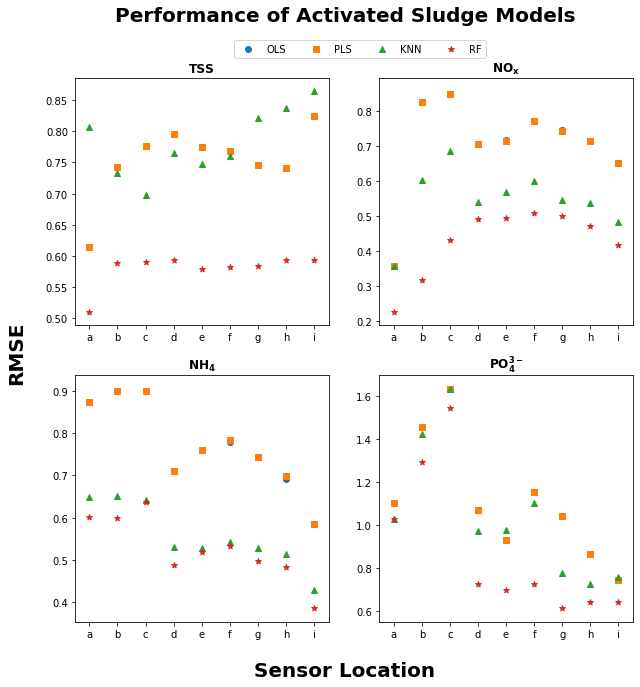

In [63]:
Model_RMSES = [Linreg_RMSE, PLS_RMSE, KNN_RMSE, RF_RMSE] 
variables = ['TSS','NOx','NH4','PO4']

fig, ax = plt.subplots(2,2, figsize=(10,10))

fig.suptitle('Performance of Activated Sludge Models', fontsize = 20, fontweight = 'bold')
ax = ax.ravel()
for i in range(4):
    ax[i].scatter([1,2,3,4,5,6,7,8,9], Linreg_RMSE[variables[i]])
    ax[i].scatter([1,2,3,4,5,6,7,8,9], PLS_RMSE[variables[i]], marker ='s')
    ax[i].scatter([1,2,3,4,5,6,7,8,9], KNN_RMSE[variables[i]], marker ='^')
    ax[i].scatter([1,2,3,4,5,6,7,8,9], RF_RMSE[variables[i]], marker ='*')
    ax[i].set_xticks([1,2,3,4,5,6,7,8,9])
    ax[i].set_xticklabels(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'])
    ax[i].set_title(Header_out[i], fontweight = 'bold')

    
fig.text(0.031, 0.5,'RMSE', va = 'center', fontsize = 20, rotation = 'vertical', fontweight = 'bold')
fig.text(0.5, 0.05,'Sensor Location', ha = 'center', fontsize = 20, fontweight = 'bold')
    
    
fig.legend(['OLS', 'PLS', 'KNN', 'RF'],
          loc = "upper center",
          borderaxespad = 0.1,
          ncol = 7,
          bbox_to_anchor = (0.5,0.9))
fig.subplots_adjust(top=0.88)

In [64]:
Linreg_RMSE.to_csv('Initial_OLS_RMSE.csv')

In [65]:
PLS_RMSE.to_csv('Initial_PLS_RMSE.csv')

In [66]:
KNN_RMSE.to_csv('Initial_KNN_RMSE.csv')

In [67]:
RF_RMSE.to_csv('Initial_RF_RMSE.csv')

In [68]:
np.min(y_test)

TSS                     9.189960
$\mathbf{NO_{x}}$       2.430490
$\mathbf{NH_4}$         0.104358
$\mathbf{PO^{3-}_4}$    0.056391
dtype: float64

In [69]:
np.max(y_test)

TSS                     36.009091
$\mathbf{NO_{x}}$        9.160803
$\mathbf{NH_4}$          9.123151
$\mathbf{PO^{3-}_4}$     8.673480
dtype: float64

In [70]:
np.mean(y_test)

TSS                     14.176423
$\mathbf{NO_{x}}$        5.665701
$\mathbf{NH_4}$          0.967725
$\mathbf{PO^{3-}_4}$     2.151130
dtype: float64

In [71]:
RF_RMSE

TSS       NOx       NH4       PO4
a  0.509918  0.226034  0.600225  1.029534
b  0.588084  0.319203  0.598371  1.294101
c  0.589878  0.432106  0.636014  1.545313
d  0.594185  0.493194  0.488097  0.725381
e  0.579705  0.493734  0.517847  0.698409
f  0.582527  0.510716  0.532611  0.724731
g  0.583399  0.500390  0.497296  0.610665
h  0.593582  0.472141  0.482410  0.642831
i  0.593417  0.417169  0.384881  0.642097

In [72]:
KNN_RMSE

TSS       NOx       NH4       PO4
a  0.807072  0.359266  0.648231  1.028035
b  0.733299  0.603171  0.650063  1.423891
c  0.698241  0.686498  0.640566  1.635761
d  0.765556  0.539858  0.529250  0.970992
e  0.747645  0.568624  0.526914  0.977414
f  0.760130  0.599648  0.542212  1.102907
g  0.820461  0.545783  0.527485  0.777027
h  0.837901  0.538108  0.514737  0.723251
i  0.863866  0.483793  0.427269  0.757308

In [73]:
PLS_RMSE 

TSS       NOx       NH4       PO4
a  0.613884  0.357490  0.874041  1.103180
b  0.743233  0.826794  0.899787  1.456654
c  0.775850  0.849226  0.898988  1.636515
d  0.796382  0.707231  0.711308  1.070080
e  0.775290  0.715760  0.759959  0.929121
f  0.767788  0.771059  0.783875  1.151697
g  0.745491  0.744344  0.743965  1.044063
h  0.741160  0.713898  0.699410  0.863902
i  0.824177  0.653082  0.585489  0.740888

In [74]:
Linreg_RMSE

TSS       NOx       NH4       PO4
a  0.613884  0.357490  0.874041  1.103180
b  0.743233  0.826794  0.899787  1.456654
c  0.775850  0.850544  0.898988  1.636515
d  0.796341  0.707231  0.711308  1.070080
e  0.775290  0.718093  0.759987  0.929121
f  0.768058  0.771059  0.779667  1.151697
g  0.745491  0.745506  0.743965  1.044063
h  0.741160  0.713898  0.690274  0.863902
i  0.824671  0.653082  0.584134  0.740888

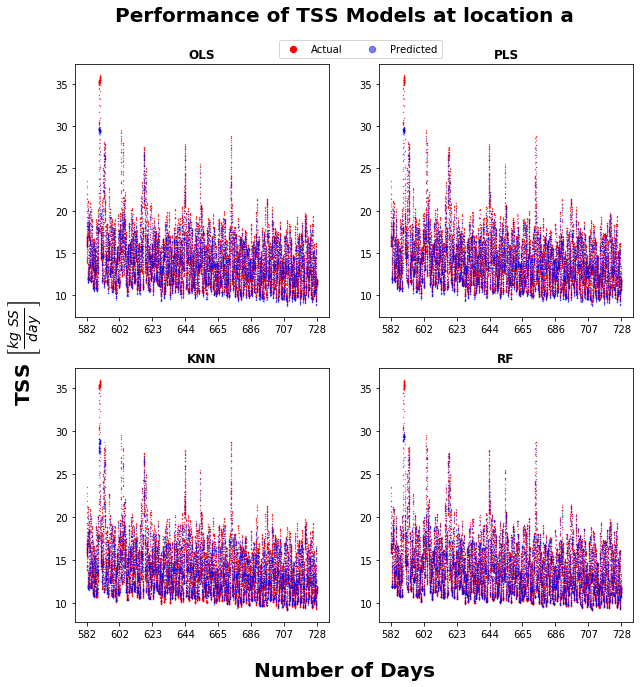

In [75]:
#Prediction Plot for TSS location a
x_axis = y_test.index.tolist()

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle('Performance of TSS Models at location a', fontsize = 20, fontweight = 'bold')
ax[0].scatter(x_axis, y_test['TSS'], s = 0.1, color = 'r')
ax[0].scatter(x_axis, X_a_model.TSS.linreg.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[1].scatter(x_axis, y_test['TSS'], s = 0.1, color = 'r')
ax[1].scatter(x_axis, X_a_model.TSS.PLS.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[2].scatter(x_axis, y_test['TSS'], s = 0.1, color = 'r')
ax[2].scatter(x_axis, X_a_model.TSS.KNN.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[3].scatter(x_axis, y_test['TSS'], s = 0.1, color = 'r')
ax[3].scatter(x_axis, X_a_model.TSS.RF.predictions, s = 0.1, alpha = 0.5, color = 'b')


titles = ['OLS','PLS','KNN','RF']

fig.text(0.031, 0.5, 'TSS '+r'$\left[\frac{kg \, \, SS}{day}\right]$', va = 'center', fontsize = 20, fontweight = 'bold', rotation = 'vertical')
fig.text(0.5, 0.05,'Number of Days', ha = 'center', fontsize = 20, fontweight = 'bold')

for i in range(4):
    ax[i].set_xticks([int(x) for x in np.linspace(y_test.index.tolist()[0],y_test.index.tolist()[-1], 8)])
    ax[i].set_xticklabels([int(x) for x in np.linspace(582,728,8)])
    ax[i].set_title(titles[i], fontweight = 'bold')
    
fig.legend(['Actual','Predicted'],
          loc = "upper center",
          borderaxespad = 0.1,
          ncol = 7,
          bbox_to_anchor = (0.5,0.9),
          markerscale = 20)
fig.subplots_adjust(top=0.90)

Text(0.5, 0.05, 'Predicted TSS $\\left[\\frac{kg \\, \\, SS}{day}\\right]$')

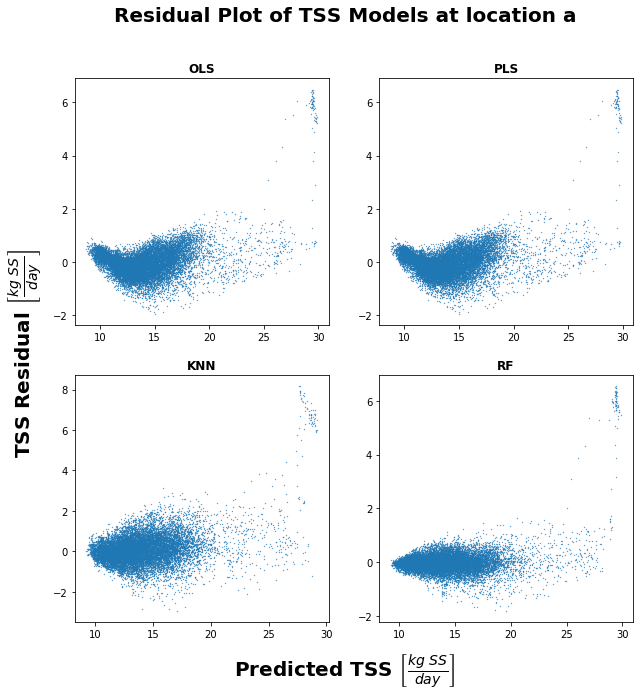

In [76]:
#Residual Plot for TSS location a


fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle('Residual Plot of TSS Models at location a', fontsize = 20, fontweight = 'bold')
ax[0].scatter(X_a_model.TSS.linreg.predictions,X_a_model.TSS.linreg.residuals, s = 0.1)
ax[1].scatter(X_a_model.TSS.PLS.predictions,X_a_model.TSS.PLS.residuals, s = 0.1)
ax[2].scatter(X_a_model.TSS.KNN.predictions,X_a_model.TSS.KNN.residuals, s = 0.1)
ax[3].scatter(X_a_model.TSS.RF.predictions,X_a_model.TSS.RF.residuals, s = 0.1)


titles = ['OLS','PLS','KNN','RF']

for i in range(4):
    ax[i].set_title(titles[i], fontweight = 'bold')

fig.text(0.031, 0.5, 'TSS Residual '+r'$\left[\frac{kg \, \, SS}{day}\right]$', va = 'center', fontsize = 20, fontweight = 'bold', rotation = 'vertical')
fig.text(0.5, 0.05,'Predicted TSS '+r'$\left[\frac{kg \, \, SS}{day}\right]$', ha = 'center', fontsize = 20, fontweight = 'bold')



In [87]:
pd.DataFrame(X_a_model.TSS.RF.predictions).to_csv('Location_a_TSS_RF_predictions.csv')
pd.DataFrame(X_a_model.TSS.RF.residuals).to_csv('Location_a_TSS_RF_residuals.csv')

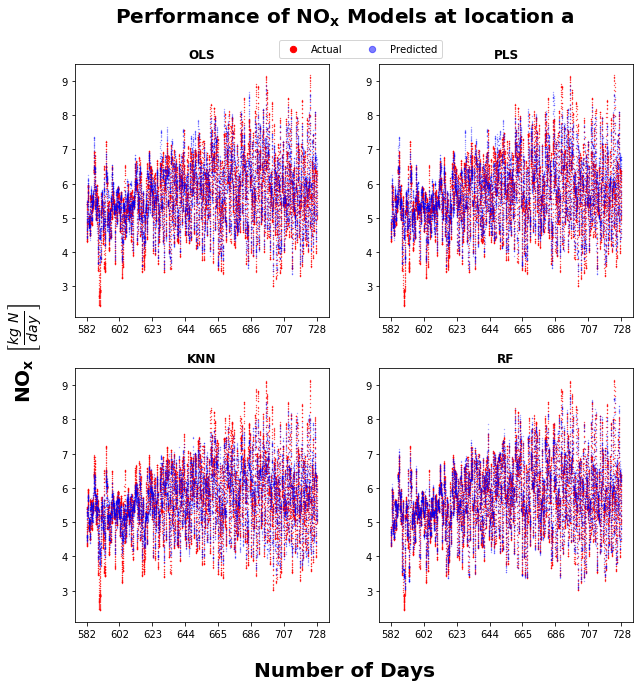

In [77]:
#Prediction Plot for NOx location a
x_axis = y_test.index.tolist()

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle(r'Performance of $\mathbf{NO_{x}}$ Models at location a', fontsize = 20, fontweight = 'bold')
ax[0].scatter(x_axis, y_test[r'$\mathbf{NO_{x}}$'], s = 0.1, color = 'r')
ax[0].scatter(x_axis, X_a_model.NOx.linreg.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[1].scatter(x_axis, y_test[r'$\mathbf{NO_{x}}$'], s = 0.1, color = 'r')
ax[1].scatter(x_axis, X_a_model.NOx.PLS.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[2].scatter(x_axis, y_test[r'$\mathbf{NO_{x}}$'], s = 0.1, color = 'r')
ax[2].scatter(x_axis, X_a_model.NOx.KNN.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[3].scatter(x_axis, y_test[r'$\mathbf{NO_{x}}$'], s = 0.1, color = 'r')
ax[3].scatter(x_axis, X_a_model.NOx.RF.predictions, s = 0.1, alpha = 0.5, color = 'b')


titles = ['OLS','PLS','KNN','RF']

fig.text(0.031, 0.5, r'$\mathbf{NO_{x}}$ '+r'$\left[\frac{kg \, \, N}{day}\right]$', va = 'center', fontsize = 20, fontweight = 'bold', rotation = 'vertical')
fig.text(0.5, 0.05,'Number of Days', ha = 'center', fontsize = 20, fontweight = 'bold')

for i in range(4):
    ax[i].set_xticks([int(x) for x in np.linspace(y_test.index.tolist()[0],y_test.index.tolist()[-1], 8)])
    ax[i].set_xticklabels([int(x) for x in np.linspace(582,728,8)])
    ax[i].set_title(titles[i], fontweight = 'bold')
    
fig.legend(['Actual','Predicted'],
          loc = "upper center",
          borderaxespad = 0.1,
          ncol = 7,
          bbox_to_anchor = (0.5,0.9),
          markerscale = 20)
fig.subplots_adjust(top=0.90)

Text(0.5, 0.05, 'Predicted $\\mathbf{NO_{x}}$ $\\left[\\frac{kg \\, \\, N}{day}\\right]$')

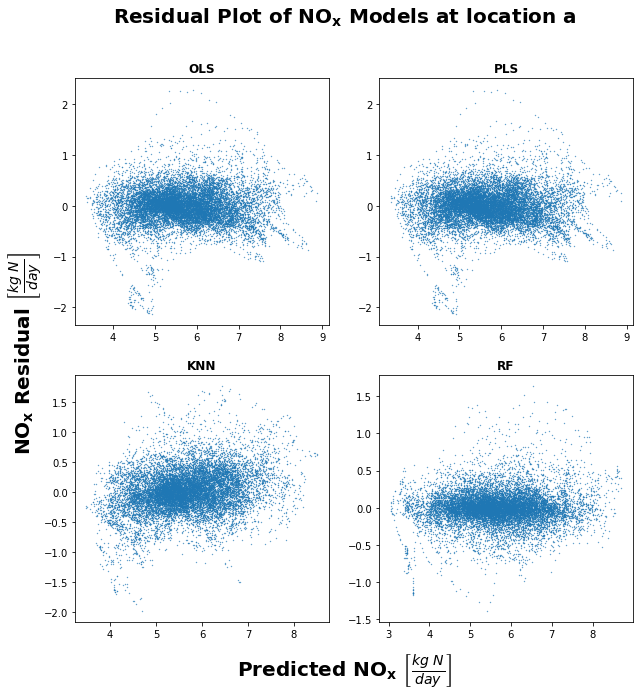

In [79]:
#Residual Plot for NOx location a


fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle(r'Residual Plot of $\mathbf{NO_{x}}$ Models at location a', fontsize = 20, fontweight = 'bold')
ax[0].scatter(X_a_model.NOx.linreg.predictions,X_a_model.NOx.linreg.residuals, s = 0.1)
ax[1].scatter(X_a_model.NOx.PLS.predictions,X_a_model.NOx.PLS.residuals, s = 0.1)
ax[2].scatter(X_a_model.NOx.KNN.predictions,X_a_model.NOx.KNN.residuals, s = 0.1)
ax[3].scatter(X_a_model.NOx.RF.predictions,X_a_model.NOx.RF.residuals, s = 0.1)

titles = ['OLS','PLS','KNN','RF']

for i in range(4):
    ax[i].set_title(titles[i], fontweight = 'bold')

fig.text(0.031, 0.5, r'$\mathbf{NO_{x}}$ Residual '+r'$\left[\frac{kg \, \, N}{day}\right]$', va = 'center', fontsize = 20, fontweight = 'bold', rotation = 'vertical')
fig.text(0.5, 0.05,r'Predicted $\mathbf{NO_{x}}$ '+r'$\left[\frac{kg \, \, N}{day}\right]$' , ha = 'center', fontsize = 20, fontweight = 'bold')




In [88]:
pd.DataFrame(X_a_model.NOx.RF.predictions).to_csv('Location_a_NOx_RF_predictions.csv')
pd.DataFrame(X_a_model.NOx.RF.residuals).to_csv('Location_a_NOx_RF_residuals.csv')

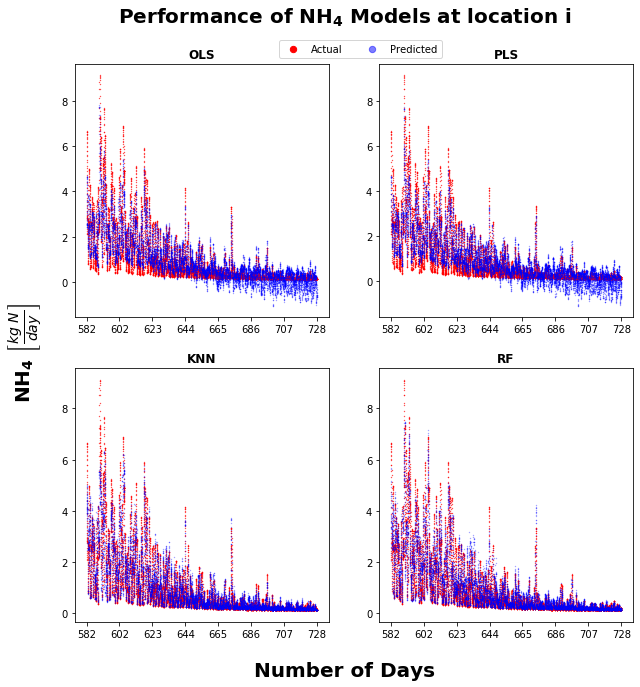

In [80]:
#Prediction Plot for NH4 location i
x_axis = y_test.index.tolist()

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle(r'Performance of $\mathbf{NH_4}$ Models at location i', fontsize = 20, fontweight = 'bold')
ax[0].scatter(x_axis, y_test[r'$\mathbf{NH_4}$'], s = 0.1, color = 'r')
ax[0].scatter(x_axis, X_i_model.NH4.linreg.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[1].scatter(x_axis, y_test[r'$\mathbf{NH_4}$'], s = 0.1, color = 'r')
ax[1].scatter(x_axis, X_i_model.NH4.PLS.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[2].scatter(x_axis, y_test[r'$\mathbf{NH_4}$'], s = 0.1, color = 'r')
ax[2].scatter(x_axis, X_i_model.NH4.KNN.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[3].scatter(x_axis, y_test[r'$\mathbf{NH_4}$'], s = 0.1, color = 'r')
ax[3].scatter(x_axis, X_i_model.NH4.RF.predictions, s = 0.1, alpha = 0.5, color = 'b')


titles = ['OLS','PLS','KNN','RF']

fig.text(0.031, 0.5, r'$\mathbf{NH_4}$ '+r'$\left[\frac{kg \, \, N}{day}\right]$', va = 'center', fontsize = 20, fontweight = 'bold', rotation = 'vertical')
fig.text(0.5, 0.05,'Number of Days', ha = 'center', fontsize = 20, fontweight = 'bold')

for i in range(4):
    ax[i].set_xticks([int(x) for x in np.linspace(y_test.index.tolist()[0],y_test.index.tolist()[-1], 8)])
    ax[i].set_xticklabels([int(x) for x in np.linspace(582,728,8)])
    ax[i].set_title(titles[i], fontweight = 'bold')
    
fig.legend(['Actual','Predicted'],
          loc = "upper center",
          borderaxespad = 0.1,
          ncol = 7,
          bbox_to_anchor = (0.5,0.9),
          markerscale = 20)
fig.subplots_adjust(top=0.90)

Text(0.5, 0.05, 'Predicted $\\mathbf{NH_{4}}$ $\\left[\\frac{kg \\, \\, N}{day}\\right]$')

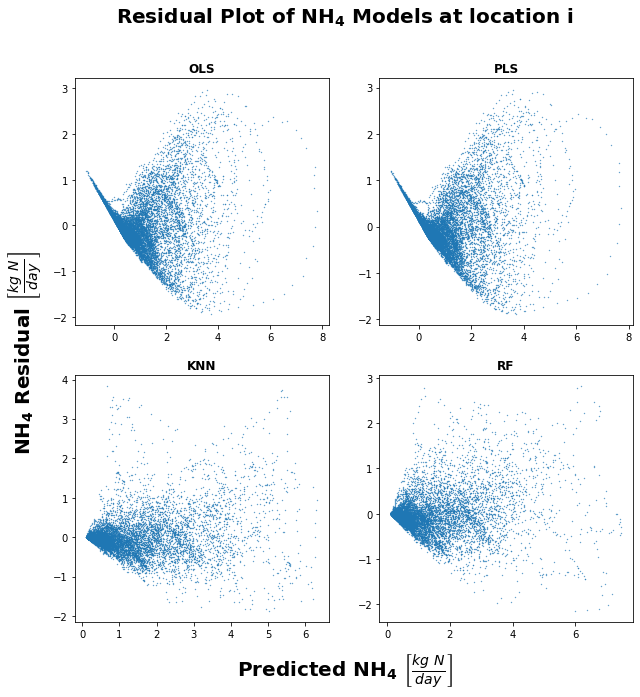

In [81]:
#Residual Plot for NH4 at location i


fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle(r'Residual Plot of $\mathbf{NH_{4}}$ Models at location i', fontsize = 20, fontweight = 'bold')
ax[0].scatter(X_i_model.NH4.linreg.predictions,X_i_model.NH4.linreg.residuals, s = 0.1)
ax[1].scatter(X_i_model.NH4.PLS.predictions,X_i_model.NH4.PLS.residuals, s = 0.1)
ax[2].scatter(X_i_model.NH4.KNN.predictions,X_i_model.NH4.KNN.residuals, s = 0.1)
ax[3].scatter(X_i_model.NH4.RF.predictions,X_i_model.NH4.RF.residuals, s = 0.1)


titles = ['OLS','PLS','KNN','RF']

for i in range(4):
    ax[i].set_title(titles[i], fontweight = 'bold')

fig.text(0.031, 0.5, r'$\mathbf{NH_{4}}$ Residual '+r'$\left[\frac{kg \, \, N}{day}\right]$', va = 'center', fontsize = 20, fontweight = 'bold', rotation = 'vertical')
fig.text(0.5, 0.05,r'Predicted $\mathbf{NH_{4}}$ '+r'$\left[\frac{kg \, \, N}{day}\right]$' , ha = 'center', fontsize = 20, fontweight = 'bold')





In [89]:
pd.DataFrame(X_i_model.NH4.RF.predictions).to_csv('Location_i_NH4_RF_predictions.csv')
pd.DataFrame(X_i_model.NH4.RF.residuals).to_csv('Location_i_NH4_RF_residuals.csv')

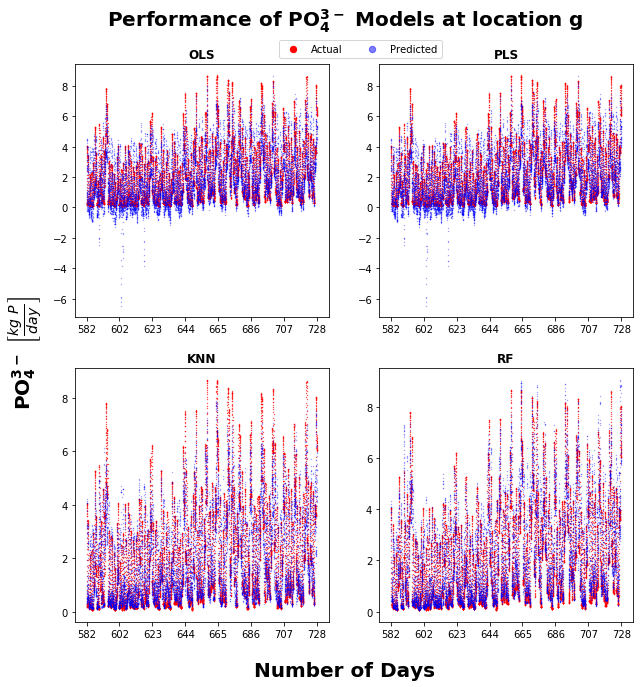

In [82]:
#Prediction Plot for PO4 at location g
x_axis = y_test.index.tolist()

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle(r'Performance of $\mathbf{PO^{3-}_4}$ Models at location g', fontsize = 20, fontweight = 'bold')
ax[0].scatter(x_axis, y_test[r'$\mathbf{PO^{3-}_4}$'], s = 0.1, color = 'r')
ax[0].scatter(x_axis, X_g_model.PO4.linreg.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[1].scatter(x_axis, y_test[r'$\mathbf{PO^{3-}_4}$'], s = 0.1, color = 'r')
ax[1].scatter(x_axis, X_g_model.PO4.PLS.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[2].scatter(x_axis, y_test[r'$\mathbf{PO^{3-}_4}$'], s = 0.1, color = 'r')
ax[2].scatter(x_axis, X_g_model.PO4.KNN.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[3].scatter(x_axis, y_test[r'$\mathbf{PO^{3-}_4}$'], s = 0.1, color = 'r')
ax[3].scatter(x_axis, X_g_model.PO4.RF.predictions, s = 0.1, alpha = 0.5, color = 'b')


titles = ['OLS','PLS','KNN','RF']

fig.text(0.031, 0.5, r'$\mathbf{PO^{3-}_4}$ '+r'$\left[\frac{kg \, \, P}{day}\right]$', va = 'center', fontsize = 20, fontweight = 'bold', rotation = 'vertical')
fig.text(0.5, 0.05,'Number of Days', ha = 'center', fontsize = 20, fontweight = 'bold')

for i in range(4):
    ax[i].set_xticks([int(x) for x in np.linspace(y_test.index.tolist()[0],y_test.index.tolist()[-1], 8)])
    ax[i].set_xticklabels([int(x) for x in np.linspace(582,728,8)])
    ax[i].set_title(titles[i], fontweight = 'bold')
    
fig.legend(['Actual','Predicted'],
          loc = "upper center",
          borderaxespad = 0.1,
          ncol = 7,
          bbox_to_anchor = (0.5,0.9),
          markerscale = 20)
fig.subplots_adjust(top=0.90)

Text(0.5, 0.05, 'Predicted $\\mathbf{PO^{3-}_4}$ $\\left[\\frac{kg \\, \\, P}{day}\\right]$')

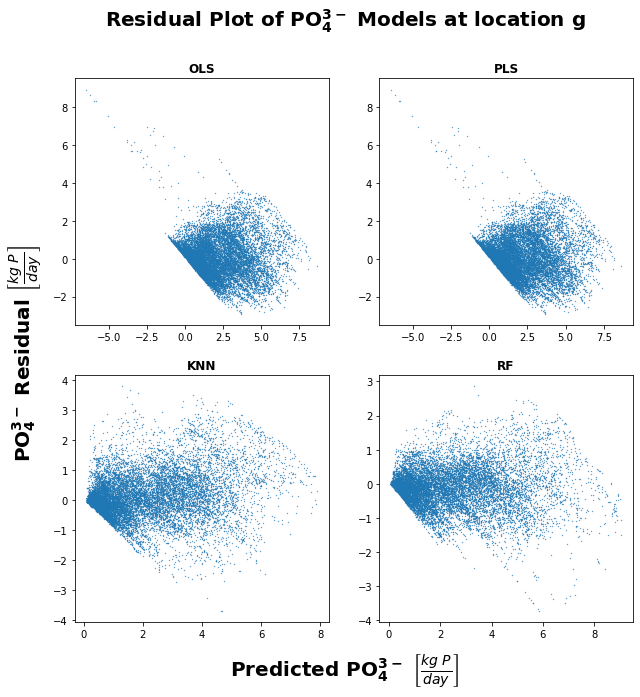

In [84]:
#Residual Plot for PO4 at location g


fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle(r'Residual Plot of $\mathbf{PO^{3-}_4}$ Models at location g', fontsize = 20, fontweight = 'bold')
ax[0].scatter(X_g_model.PO4.linreg.predictions,X_g_model.PO4.linreg.residuals, s = 0.1)
ax[1].scatter(X_g_model.PO4.PLS.predictions,X_g_model.PO4.PLS.residuals, s = 0.1)
ax[2].scatter(X_g_model.PO4.KNN.predictions,X_g_model.PO4.KNN.residuals, s = 0.1)
ax[3].scatter(X_g_model.PO4.RF.predictions,X_g_model.PO4.RF.residuals, s = 0.1)


titles = ['OLS','PLS','KNN','RF']

for i in range(4):
    ax[i].set_title(titles[i], fontweight = 'bold')
    
    
fig.text(0.031, 0.5, r'$\mathbf{PO^{3-}_4}$ Residual '+r'$\left[\frac{kg \, \, P}{day}\right]$', va = 'center', fontsize = 20, fontweight = 'bold', rotation = 'vertical')
fig.text(0.5, 0.05,r'Predicted $\mathbf{PO^{3-}_4}$ '+r'$\left[\frac{kg \, \, P}{day}\right]$' , ha = 'center', fontsize = 20, fontweight = 'bold')




In [90]:
pd.DataFrame(X_g_model.PO4.RF.predictions).to_csv('Location_g_PO4_RF_predictions.csv')
pd.DataFrame(X_g_model.PO4.RF.residuals).to_csv('Location_g_PO4_RF_residuals.csv')